In [3]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [4]:

def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp, sr=None)
        
        print('extracting %s' % (fp), len(X), sr)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    
    print("In plot_waves")
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        print("plotting", n, f)
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f), sr=16000)
        plt.title(n.title())
        i += 1
        
    print("after for")
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=16000)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

In [ ]:
# plot_waves(sound_class_names, raw_sounds)


# plot_log_power_specgram(sound_class_names, raw_sounds)

In [ ]:
file_folder = './dataset'


sound_file_names = ["0c5027de_nohash_0.wav",
                    "0d2bcf9d_nohash_0.wav",
                    "0f7205ef_nohash_0.wav",
                    "4c7c95de_nohash_1.wav",
                    "7b2e879e_nohash_0.wav"]

sound_class_names = ["down","go","left","right","up"]

sound_file_paths = list(map(lambda f_tup: os.path.join(file_folder, f_tup[0], f_tup[1]), 
                            zip(sound_class_names, sound_file_names)))


print(sound_file_paths)
raw_sounds = load_sound_files(sound_file_paths)
print(len(raw_sounds))

plot_specgram(sound_class_names, raw_sounds)
# print(raw_sounds)

['./dataset/down/0c5027de_nohash_0.wav', './dataset/go/0d2bcf9d_nohash_0.wav', './dataset/left/0f7205ef_nohash_0.wav', './dataset/right/4c7c95de_nohash_1.wav', './dataset/up/7b2e879e_nohash_0.wav']
extracting ./dataset/down/0c5027de_nohash_0.wav 16000 16000
extracting ./dataset/go/0d2bcf9d_nohash_0.wav 16000 16000
extracting ./dataset/left/0f7205ef_nohash_0.wav 16000 16000
extracting ./dataset/right/4c7c95de_nohash_1.wav 16000 16000
extracting ./dataset/up/7b2e879e_nohash_0.wav 16000 16000
5


In [110]:
class_labels = {
    'down' : 0,
    'go'   : 1,
    'left' : 2,
    'right': 3,
    'up'   : 4
}

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += window_size

def extract_mfccs(X, sample_rate, time_interval=0.1, num_mfcc=40):
    
    mfccs = np.array([])
    window_size = int(len(X) / 10)
    
    for (start,end) in windows(X, window_size):
        if len(X[start:end]) != window_size:
            continue
        mfcc = np.mean(librosa.feature.mfcc(y=X[start:end], sr=sample_rate, n_mfcc=num_mfcc).T,axis=0)
        
        mfccs = np.append(mfccs, mfcc)
    
    return mfccs

def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name, sr=None)
    stft = np.abs(librosa.stft(X))
    
    mfccs = extract_mfccs(X, sample_rate)
    mfcc_whole_audio = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate
(y=X).T, axis=0)
    return mfccs, mfcc_whole_audio, chroma,mel,contrast,tonnetz,zero_crossing_rate

def parse_audio_files(parent_dir, sub_dirs, file_ext='*.wav'):
    
#     +32 -40 +360
    features, labels = np.empty((0, 594)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, mfcc_whole_audio, chroma, mel, contrast,tonnetz, zero_crossing_rate = extract_feature(fn)
            ext_features = np.hstack([mfccs,mfcc_whole_audio,chroma,mel,contrast,tonnetz, zero_crossing_rate])
            features = np.vstack([features, ext_features])
            labels = np.append(labels, class_labels[sub_dir])
            
    return np.array(features), np.array(labels, dtype = np.int)

In [111]:
parent_dir = 'dataset'

sub_dirs = ['down','go','left', 'right', 'up']

features, labels = parse_audio_files(parent_dir, sub_dirs)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


(11826, 594)
(11826,)
(594,)
(594,)
(11826, 594)
(11826,)


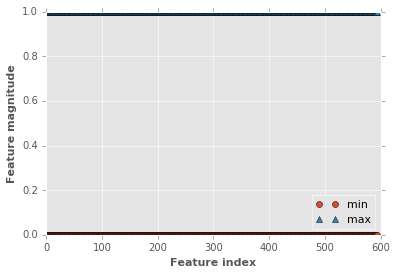

In [142]:
print(features.shape)
print(labels.shape)

plt.plot(features.min(axis=0), 'o', label="min")
plt.plot(features.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
 # Compute the minimum value per feature on the training set
min_on_training = features.min(axis=0)  
print((min_on_training.shape))
# Compute the range of each feature (max - min) on the training set
range_on_training = (features - min_on_training).max(axis=0)
print((range_on_training.shape))

features = (features - min_on_training) / range_on_training

print(features.shape)
print(labels.shape)

import matplotlib.pyplot as plt

# plt.plot(features.min(axis=0), 'o', label="min")
# plt.plot(features.max(axis=0), '^', label="max")
# plt.legend(loc=4)
# plt.xlabel("Feature index")
# plt.ylabel("Feature magnitude")

plt.show()

In [145]:
np.savetxt("features.csv", features, delimiter=",")
np.savetxt("labels.csv", labels, delimiter=",")

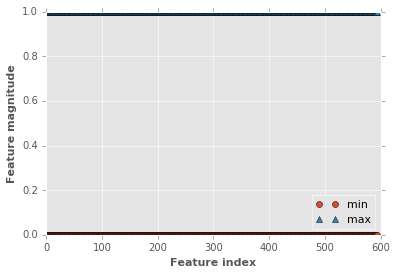

In [113]:
plt.plot(features.min(axis=0), 'o', label="min")
plt.plot(features.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

In [146]:
from sklearn.model_selection import train_test_split

X_all, _, y_all, _ = train_test_split(
    features, labels, stratify=labels, train_size=0.5, random_state=42)

In [199]:


cnt = list(map(lambda x: labels.tolist().count(x), [i for i in range(5)]))
print(cnt)
np.histogram(cnt, bins=5)

[2359, 2372, 2353, 2367, 2375]


(array([1, 1, 0, 1, 2]),
 array([ 2353. ,  2357.4,  2361.8,  2366.2,  2370.6,  2375. ]))

In [147]:
print(X_all.shape)
print(y_all.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, train_size=0.9, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train)

(5913, 594)
(5913,)
(5321, 594)
(592, 594)
(5321,)
(592,)
[2 2 2 ..., 0 1 4]


In [158]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, stratify=labels, train_size=0.9, random_state=42)

print(X_train.shape)
clf = SVC(kernel='rbf', C=10, gamma=0.1, decision_function_shape='ovo')
clf.fit(X_train, y_train)

print("Training set score: {:.3f}".format(clf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test, y_test)))

(10643, 594)
Training set score: 0.997
Test set score: 0.831


In [156]:
from sklearn.metrics import confusion_matrix

y_test_pred = clf.predict(X_test)

conf_mat = confusion_matrix(y_test, y_test_pred)

print(conf_mat)
for idx, arr in enumerate(conf_mat):
    print(list(map(lambda d: float(format(d/sum(arr), '.3f')), arr)))

[[196  22   4   8   6]
 [ 21 195   3   5  13]
 [ 13  10 187  15  10]
 [  8  10  12 202   5]
 [  5  14  13   3 203]]
[0.831, 0.093, 0.017, 0.034, 0.025]
[0.089, 0.823, 0.013, 0.021, 0.055]
[0.055, 0.043, 0.796, 0.064, 0.043]
[0.034, 0.042, 0.051, 0.852, 0.021]
[0.021, 0.059, 0.055, 0.013, 0.853]


In [148]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1, 10]}

clf = SVC(kernel='rbf')

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=100)

grid_search.fit(X_train, y_train)

print("Test set score: {:.3f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] gamma=0.001, C=0.001 ............................................
[CV] ............. gamma=0.001, C=0.001, score=0.200750, total=  25.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.2s remaining:    0.0s
[CV] gamma=0.001, C=0.001 ............................................
[CV] ............. gamma=0.001, C=0.001, score=0.200939, total=  24.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[CV] gamma=0.001, C=0.001 ............................................
[CV] ............. gamma=0.001, C=0.001, score=0.201128, total=31.1min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 32.5min remaining:    0.0s
[CV] gamma=0.001, C=0.001 ............................................
[CV] ............. gamma=0.001, C=0.001, score=0.201128, total=38.2min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 70.9min remaining:    0.0s
[CV] gamma=0.001, C=0.001 ........................

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


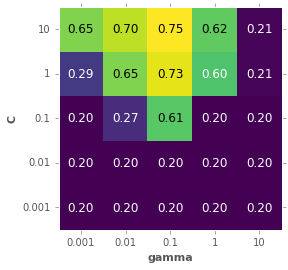

In [149]:
import pandas as pd
from mglearn.tools import heatmap
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)

scores = np.array(results.mean_test_score).reshape(5, 5)
# plot the mean cross-validation scores
heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis");

In [162]:
from numpy import genfromtxt

X_all_nn = genfromtxt('nn_features.csv', delimiter=',')
y_all_nn = genfromtxt('nn_labels.csv', delimiter=',')

y_all_nn = np.argmax(y_all_nn, axis=1)

In [165]:
print(X_all_nn.shape)
print(y_all_nn.shape)

(11826, 1960)
(11826,)


In [173]:
min_on_training = X_all_nn.min(axis=0)  
print((min_on_training.shape))
# Compute the range of each feature (max - min) on the training set
range_on_training = (X_all_nn - min_on_training).max(axis=0)
print((range_on_training.shape))

X_all_nn = (X_all_nn - min_on_training) / range_on_training

(1960,)
(1960,)


In [174]:
print(X_all_nn.shape)
print(y_all_nn.shape)

(11826, 1960)
(11826,)


In [166]:
from sklearn.svm import SVC

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_all_nn, y_all_nn, stratify=y_all_nn, train_size=0.9, random_state=42)

print(X_train_nn.shape)

clf = SVC(kernel='rbf', C=1, gamma=0.1)
clf.fit(X_train_nn, y_train_nn)

print("Training set score: {:.3f}".format(clf.score(X_train_nn, y_train_nn)))
print("Test set score: {:.3f}".format(clf.score(X_test_nn, y_test_nn)))

(10643, 1960)
Training set score: 1.000
Test set score: 0.211


In [175]:
X_sub_nn, _, y_sub_nn, _ = train_test_split(
    X_all_nn, y_all_nn, stratify=y_all_nn, train_size=0.3, random_state=42)

X_sub_train_nn, X_sub_test_nn, y_sub_train_nn, y_sub_test_nn = train_test_split(
    X_sub_nn, y_sub_nn, stratify=y_sub_nn, train_size=0.9, random_state=42)

print(X_sub_train_nn.shape)
print(y_sub_train_nn.shape)
print(X_sub_test_nn.shape)
print(y_sub_test_nn.shape)

(3192, 1960)
(3192,)
(355, 1960)
(355,)


In [182]:
clf = SVC(kernel='rbf', C=10, gamma=0.01)
clf.fit(X_sub_train_nn, y_sub_train_nn)

print("Training set score: {:.3f}".format(clf.score(X_sub_train_nn, y_sub_train_nn)))
print("Test set score: {:.3f}".format(clf.score(X_sub_test_nn, y_sub_test_nn)))

Training set score: 0.991
Test set score: 0.637
